In [34]:
import pandas as pd
import os
import torch 
import torch.nn as nn
import torchvision
import codecs
from collections import Counter,defaultdict
from nltk.corpus import stopwords
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import string

In [41]:
all_words = []
tweets=[]
data_pd = pd.read_csv("../data/Labelled_tweets_v1.csv")
print(data_pd.head(3))
data_tweet = data_pd['Tweet']
for i in data_tweet:
    j = i.split()
    tweets.append(j)
    for k in j:
        all_words.append(k)

                                               Tweet      UserHandle Party  \
0  a no of people approach me daily worried abt t...  ArvindKejriwal   AAP   
1  its now revealed that our fms silence on the p...  ArvindKejriwal   AAP   
2  pnb scam started in is going on till today the...  ArvindKejriwal   AAP   

      Issue        Stance  
0       GST  Disagreement  
1  PNB Scam       Neutral  
2  PNB Scam       Neutral  


In [42]:
issues_pd = data_pd['Issue']
stance_pd = data_pd['Stance']

#all_words = tweets
word2cnt = Counter(all_words)
stop_words = stopwords.words('english')

In [43]:
with codecs.open('vocab_real.csv', 'w', 'utf-8') as fout:
  fout.write("{}{}1000000000\n{}{}1000000000\n{}{}1000000000\n{}{}1000000000\n".format("<PAD>",",", "<UNK>",",", "<S>",",", "</S>",","))
  for word, cnt in word2cnt.most_common(len(word2cnt)):
    if(word not in stop_words):
      fout.write("{}{}{} \n".format(word,',',cnt))

In [44]:
issues = []
for iss in issues_pd:
  if iss not in issues:
    issues.append(iss)
    
print(issues)

word_counts = pd.read_csv("vocab_real.csv",header=None)
data_list = data_pd.values
print(data_list[0:5])

['GST', 'PNB Scam', 'FDIPolicy', 'Padmavati film screening', 'Cauvery SC Verdict', 'Jallikattu ban', 'GDP growth', 'RightToPrivacy SC Verdict', 'Demonetisation', 'Swacch Bharat', 'Aadhar linking', 'Triple Talaq SC verdict', 'TripleTalaqBill', 'lgp price hike', 'reservation', 'Beef Ban', 'Inflation control', 'nsc and ppf rate cuts', 'Ram Mandir', 'EVM tampering', 'Fodder scam', 'hike in oil prices', 'Rohingyas', 'acchedin']
[['a no of people approach me daily worried abt the safety of their money in banks considering large no of bank frauds coming to light daily pm may kindly inform the public which bank is safe for people to keep their money URL sir there is a big rumour people are very skeptical that their saved money in the banks can go for a toss anytime hope wish pray that you our people all of us save the hard earned money in banks improve our incomes strengthen the income tax system'
  'ArvindKejriwal' 'AAP' 'GST' 'Disagreement']
 ['its now revealed that our fms silence on the pn

In [45]:
data_tweet = data_tweet.values.tolist()
for i in range(0,len(data_tweet)):
    data_tweet[i] = data_tweet[i].split()
    
print(data_tweet[0:5])

[['a', 'no', 'of', 'people', 'approach', 'me', 'daily', 'worried', 'abt', 'the', 'safety', 'of', 'their', 'money', 'in', 'banks', 'considering', 'large', 'no', 'of', 'bank', 'frauds', 'coming', 'to', 'light', 'daily', 'pm', 'may', 'kindly', 'inform', 'the', 'public', 'which', 'bank', 'is', 'safe', 'for', 'people', 'to', 'keep', 'their', 'money', 'URL', 'sir', 'there', 'is', 'a', 'big', 'rumour', 'people', 'are', 'very', 'skeptical', 'that', 'their', 'saved', 'money', 'in', 'the', 'banks', 'can', 'go', 'for', 'a', 'toss', 'anytime', 'hope', 'wish', 'pray', 'that', 'you', 'our', 'people', 'all', 'of', 'us', 'save', 'the', 'hard', 'earned', 'money', 'in', 'banks', 'improve', 'our', 'incomes', 'strengthen', 'the', 'income', 'tax', 'system'], ['its', 'now', 'revealed', 'that', 'our', 'fms', 'silence', 'on', 'the', 'pnb', 'scam', 'was', 'to', 'protect', 'his', 'lawyer', 'daughter', 'who', 'was', 'paid', 'a', 'large', 'retainer', 'by', 'the', 'accused', 'just', 'a', 'month', 'before', 'the', 

In [46]:
max_tweet_size = 0
for i in data_tweet:
    if(len(i)>max_tweet_size):
        max_tweet_size = len(i)
        
print(max_tweet_size)

120


In [47]:
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said','a','URL','USER_MENTION']
tweets_after_stop_words=[]
for i in data_tweet:
    tweet = []
    for j in i:
        if(j not in stopset):
            tweet.append(j)
    tweets_after_stop_words.append(tweet)

In [67]:
class Net(nn.Module):
    def __init__(self,vocab_size, hidden_size,input_size):
        super(Net,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.word_embeddings = nn.Embedding(vocab_size+106,100)
        self.GRU = nn.GRU(100,self.hidden_size, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, 24)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x_input,hidden_state):
        embedded = self.word_embeddings(x_input)
        #print(embedded.shape)
        #output = embedded.view(-1,-1, self.hidden_size)
        output, hn = self.GRU(embedded)
        #hn_ = hn[0].reshape(x_input.shape[0],output.shape[1]*output.shape[2])
        #print(output.shape)
        linear = self.linear(hn[0])
        #print(linear.shape)
        class_labels = self.softmax(linear)
        
        return class_labels

    def H_t0(self, batch_size):
        return torch.zeros(1,batch_size,self.hidden_size)

In [ ]:
issues_pd = data_pd['Issue']
stance_pd = data_pd['Stance']

all_words = tweets
word2cnt = Counter(all_words)
stop_words = stopwords.words('english')

In [19]:
def issue_vocab(issues,want = 'issue2id'):
    if(want == 'issue2id'):
        issue2idx = {issue:idx for idx,issue in enumerate(issues)}
        return issue2idx
    
    else:
        idx2issue = {idx:issue for idx,issue in enumerate(issues)}
        return idx2issue
    
def sent_vocab(want = 'sent2id'):
    sent2id = {'Disagreement':0,'Neutral':1,'Agreement':2}
    id2sent = {0:'Disagreement',1:'Neutral',2:'Agreement'}
    if(want == 'sent2id'):
        return sent2id

    else:
        #idx2issue = {idx:issue for idx,issue in enumerate(issues)}
        return idx2sent

def load_vocab():
    load_words = open("vocab_real.csv").readlines()
    for i in range(len(load_words)):
        load_words[i] = load_words[i].split(',')
    vocab = [load_words[i][0] for i in range(len(load_words))]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    return word2idx, idx2word

In [20]:
def create_data(tweets, issue_, sentiments,issues):
    #print(len(tweets))
    stop_words = ['the','of','in','and','a','is','on','this','all','it','will','for','to','be','with',
              'at','are','u','has','that','by','from', 'as','was','have','its','an','if','been','be','also','should','which']
    max_tweet_size = 120
    word2idx,idx2word = load_vocab()
    issue2idx = issue_vocab(issues,'issue2id')
    sent2idx = sent_vocab()

    x_tweet, y_issue, y_label = [], [], []
    for tweet,issue,sent in zip(tweets, issue_, sentiments):
        x = [word2idx.get(word, 1) for word in (tweet + u" </S>").split() if word not in stop_words]
        x = np.array(x)
        t = np.zeros(max_tweet_size)
        if len(x)<=max_tweet_size:
            t[:len(x)] = x
        else:
            t = x[:max_tweet_size]

        #print(issue)
        y_i = [issue2idx.get(issue,1)]
        y_l = [sent2idx.get(sent,1)]

        x_tweet.append(t)
        y_issue.append(y_i)
        y_label.append(y_l)
    #print(len(x_tweet))
    return np.array(x_tweet), np.array(y_issue), np.array(y_label)

In [21]:
def batches_train(data_x,data_y,batch_size, idx):
    start =  batch_size*idx
    end = start + batch_size
    if(end>len(data_x)):
        return data_x[start:], data_y[start:]
    return data_x[start:end], data_y[start:end]

def batches_test(data_x,data_y,batch_size, idx):
    start =  batch_size*idx
    end = start + batch_size
    return data_x[start:end], data_y[start:end]

In [48]:
num_issues = 24#len(issues)
epochs = 10
input_size = 100
vocab_size = len(word_counts)
output_size_issue = num_issues
output_size_label = 3
hidden_size = 256
batch_size = 32
#n_iters = int(len(x_train)/batch_size)
lr = 0.01

num_issues = len(issues_pd.unique())

In [49]:
epoch_loss_all_issues = defaultdict(list)
metrics_dict = defaultdict(list)
predicted_list = defaultdict(list)
ground_truth = defaultdict(list)

In [51]:
num_train = int(0.8*len(tweets))
num_test = len(tweets)-num_train

print(num_train,num_test,num_train+num_test)

5753 1439 7192


/home/bedanta/ml/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0.0


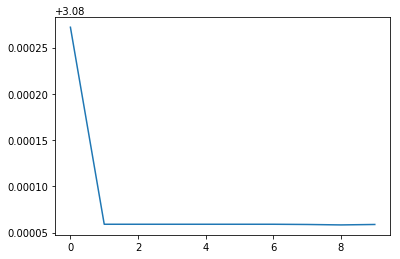

In [76]:

net = Net(vocab_size, hidden_size,100)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net.parameters(),lr=0.1)

# data_withot_one_issue = data_pd[data_pd.Issue != one]
# data_with_the_issue = data_pd[data_pd.Issue == one]

# data_list_with = data_withot_one_issue.values
# data_list_without = data_with_the_issue.values
data_pd_values = data_pd.values

tweets_train = data_pd_values[:num_train,0]
#print(tweets_train[0])
issue_train = data_pd_values[:num_train,3]
label_train = data_pd_values[:num_train,4]

tweets_test = data_pd_values[num_train:num_train+num_test,0]
issue_test = data_pd_values[num_train:num_train+num_test,3]
label_test = data_pd_values[num_train:num_train+num_test,4]

x_tweet_train,y_issue_train, y_label_train = create_data(tweets_train,issue_train,label_train,issues)
#print(x_tweet_train[0])
x_tweet_test,y_issue_test, y_label_test = create_data(tweets_test,issue_test,label_test,issues)
x_tweet_test, y_label_test = Variable(torch.LongTensor(x_tweet_test)), Variable(torch.LongTensor(y_label_test))
#print(x_tweet_test)
train_losses = []
test_losses = []

epoch_losses = []
for e in range(0,10):
    epoch_loss = 0
    for idx in range(0,int(len(x_tweet_train)/batch_size)+1):
        #net.zero_grad()
        optimizer.zero_grad()
        batch_x, batch_y = batches_train(x_tweet_train,y_issue_train,batch_size,idx)
        batch_x = Variable(torch.LongTensor(batch_x))
        batch_y = Variable(torch.LongTensor(batch_y))
        batch_y = batch_y.reshape(batch_y.shape[0])
        encoder_hidden = Variable(net.H_t0(batch_y.shape[0]))
        output = net(batch_x,encoder_hidden)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.data[0]
    epoch_loss /= len(x_tweet_train)/batch_size
    epoch_losses.append(epoch_loss)

encoder_hidden_test = Variable(net.H_t0(len(x_tweet_test)))
predicted_output = net(x_tweet_test,encoder_hidden_test)
predicted_output = predicted_output.reshape(len(x_tweet_test),24)
predicted_output = predicted_output.detach().numpy()
predicted_output = np.argmax(predicted_output,axis = 1)
#predicted_list[one] = predicted_output
#ground_truth[one] = y_label_test
accuracy = accuracy_score(predicted_output,y_label_test)
print(accuracy)
plt.plot(epoch_losses)
plt.show()
#epoch_loss_all_issues[one] = epoch_losses


In [77]:
# encoder_hidden_test = Variable(net.H_t0(len(x_tweet_test)))
# predicted_output = net(x_tweet_test,encoder_hidden_test)
# predicted_output = predicted_output.reshape(len(x_tweet_test),24)
# predicted_output = predicted_output.detach().numpy()
# predicted_output = np.argmax(predicted_output,axis = 1)
# #predicted_list[one] = predicted_output
# #ground_truth[one] = y_label_test
# accuracy = accuracy_score(predicted_output,y_label_test)
# print(accuracy)
# plt.plot(epoch_losses)
# plt.show()

array([8, 8, 8, ..., 8, 8, 8])